In [15]:
import requests

In [16]:
import numpy as np
import pandas as pd

In [17]:
import geopandas as gpd

In [18]:
import matplotlib.pyplot as plt

In [19]:
# Get TAZ data from jobpop data locally
jobpop = pd.read_csv('data_jobpop.csv')


## TAZ Data Loading + Processing

In [20]:
# download TAZ data from SFTCA

url = 'https://www.sfcta.org/sites/default/files/2019-06/TAZ981.zip'

with open('TAZ981.zip', 'wb') as f:
    r = requests.get(url)
    f.write(r.content)

In [21]:
taz = gpd.read_file('zip://TAZ981.zip')

In [22]:
taz['taz']=taz['TAZ']

In [23]:
taz.head()

,TAZ,geometry,taz
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5


## Population+Job Data Loading, Processing

In [24]:
jobpop.head()

,taz,pop2015,tot2015,jobpop2015,pop2050,tot2050,jobpop2050
0,1,805,85,890,1020,105,1125
1,2,1264,58,1322,1671,58,1729
2,3,823,72,895,985,71,1056
3,4,1388,115,1503,1796,116,1912
4,5,1367,53,1420,1448,39,1487


In [25]:
jp2050=jobpop[['taz','jobpop2050']].copy()

In [26]:
jp2050.head()

,taz,jobpop2050
0,1,1125
1,2,1729
2,3,1056
3,4,1912
4,5,1487


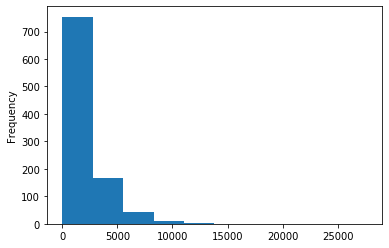

In [27]:
# Add a bar graph to the current (empty) Matplotlib chart
#plt.bar(['taz'], jp2050)

jp2050['jobpop2050'].plot.hist()

# Display the current chart
plt.show()

In [28]:
jobpop_plot = taz.copy(deep=True)
jobpop_plot = jobpop_plot.merge(jp2050, on='taz')
jobpop_plot.head()

,TAZ,geometry,taz,jobpop2050
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,1125
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,1729
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,1056
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,1912
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,1487


In [29]:
# normalize tnc data by taz AREA

jobpop_plot['AREA1']=jobpop_plot['geometry'].area
jobpop_plot['jobpop_AREA']=jobpop_plot['jobpop2050']/jobpop_plot['AREA1']


In [30]:
# add weight factor variable(column) to data
wt1=[]

for a in range(len(jobpop_plot)):
    wt1.append(0)
    
len(wt1)

981

In [31]:
jobpop_plot['jp_WeightFac'] = wt1

jobpop_plot.head()

,TAZ,geometry,taz,jobpop2050,AREA1,jobpop_AREA,jp_WeightFac
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,1125,9.310735e+05,0.001208,0
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,1729,1.825218e+06,0.000947,0
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,1056,1.360855e+06,0.000776,0
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,1912,1.596024e+06,0.001198,0
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,1487,1.064261e+06,0.001397,0


In [32]:
# use 25%, 50%, and 75% as guides, set weight factors for each taz data

jobpop_plot.jobpop_AREA.describe()
sta1=jobpop_plot.jobpop_AREA.describe()
sta1

count    981.000000
mean       0.003375
std        0.005689
min        0.000000
25%        0.000942
50%        0.001505
75%        0.003049
max        0.047531
Name: jobpop_AREA, dtype: float64

In [33]:
# Weight Factor Assignment

jobpop_p95=np.percentile(jobpop_plot['jobpop_AREA'], 95)

jobpop_plot.loc[jobpop_plot['jobpop_AREA'] <= sta1['50%'], 'jp_WeightFac'] = 0.0
jobpop_plot.loc[(jobpop_plot['jobpop_AREA'] >= sta1['50%']) & (jobpop_plot['jobpop_AREA'] <= sta1['75%']), 'jp_WeightFac'] = 1.0
jobpop_plot.loc[(jobpop_plot['jobpop_AREA'] >= sta1['75%']) & (jobpop_plot['jobpop_AREA'] <= jobpop_p95), 'jp_WeightFac'] = 2.0
jobpop_plot.loc[jobpop_plot['jobpop_AREA'] >= jobpop_p95, 'jp_WeightFac'] = 4.0

In [34]:
#jobpop_chosen['jobpop_AREA']=jobpop_plot['jobpop_AREA'] >= sta1['75%']

In [35]:
jobpop_plot.head()

,TAZ,geometry,taz,jobpop2050,AREA1,jobpop_AREA,jp_WeightFac
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,1125,9.310735e+05,0.001208,0.0
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,1729,1.825218e+06,0.000947,0.0
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,1056,1.360855e+06,0.000776,0.0
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,1912,1.596024e+06,0.001198,0.0
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,1487,1.064261e+06,0.001397,0.0


In [36]:
# jobpop_plot['WtFac_AREA1']=jobpop_plot['WeightFac']/jobpop_plot['AREA1']

In [37]:
# jobpop_plot.head()

## TNC Data Loading + Processing

In [38]:
# Get TAZ data from TNC data locally
tnc = pd.read_csv('trip_stats_taz_0.csv')

In [39]:
tnc.head()

,taz,day_of_week,hour,pickups,dropoffs
0,1,0,3,0.6,0.4
1,1,0,4,0.0,0.4
2,1,0,5,0.6,0.6
3,1,0,6,0.8,1.0
4,1,0,7,0.6,0.8


In [40]:
# Group data by TAZ

tnc2=tnc.groupby('taz').mean()

In [41]:
type(tnc2)

pandas.core.frame.DataFrame

In [42]:
tnc2.head()

,day_of_week,hour,pickups,dropoffs
taz,,,,
1,3.0,14.5,0.674702,0.611012
2,3.0,14.5,1.423810,1.621131
3,3.0,14.5,0.836905,0.896429
4,3.0,14.5,3.828869,4.127976
5,3.0,14.5,0.661905,0.522321


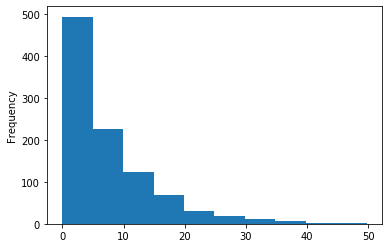

In [43]:
# Add a bar graph to the current (empty) Matplotlib chart
#plt.bar(['taz'], jp2050)

tnc2['pickups'].plot.hist()

# Display the current chart
plt.show()

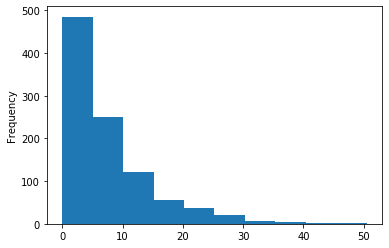

In [44]:
# Add a bar graph to the current (empty) Matplotlib chart
#plt.bar(['taz'], jp2050)

tnc2['dropoffs'].plot.hist()

# Display the current chart
plt.show()

In [45]:
# average pickups+dropoffs

tnc2['pick_drop']=(tnc2['pickups']+tnc2['dropoffs'])/2
tnc2.head()

,day_of_week,hour,pickups,dropoffs,pick_drop
taz,,,,,
1,3.0,14.5,0.674702,0.611012,0.642857
2,3.0,14.5,1.423810,1.621131,1.522470
3,3.0,14.5,0.836905,0.896429,0.866667
4,3.0,14.5,3.828869,4.127976,3.978423
5,3.0,14.5,0.661905,0.522321,0.592113


In [46]:
tnc2.pick_drop.describe()

count    981.000000
mean       7.361588
std        7.254857
min        0.000000
25%        1.940327
50%        4.972024
75%       10.001190
max       50.099702
Name: pick_drop, dtype: float64

In [47]:
tnc_plot = taz.copy(deep=True)
tnc_plot = tnc_plot.merge(tnc2, on='taz')
tnc_plot.head()

,TAZ,geometry,taz,day_of_week,hour,pickups,dropoffs,pick_drop
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,3.0,14.5,0.674702,0.611012,0.642857
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,3.0,14.5,1.423810,1.621131,1.522470
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,3.0,14.5,0.836905,0.896429,0.866667
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,3.0,14.5,3.828869,4.127976,3.978423
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,3.0,14.5,0.661905,0.522321,0.592113


In [48]:
# normalize tnc2 data by taz AREA

tnc_plot['AREA2']=tnc_plot['geometry'].area
tnc_plot['tnc_AREA']=tnc_plot['pick_drop']/tnc_plot['AREA2']

In [49]:
tnc_plot.head()

,TAZ,geometry,taz,day_of_week,hour,pickups,dropoffs,pick_drop,AREA2,tnc_AREA
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,3.0,14.5,0.674702,0.611012,0.642857,9.310735e+05,6.904473e-07
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,3.0,14.5,1.423810,1.621131,1.522470,1.825218e+06,8.341307e-07
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,3.0,14.5,0.836905,0.896429,0.866667,1.360855e+06,6.368546e-07
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,3.0,14.5,3.828869,4.127976,3.978423,1.596024e+06,2.492709e-06
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,3.0,14.5,0.661905,0.522321,0.592113,1.064261e+06,5.563609e-07


In [50]:
wt2=[]

for a in range(len(tnc_plot)):
    wt2.append(0)
    
len(wt2)

981

In [51]:
tnc_plot['tnc_WeightFac'] = wt2

tnc_plot.head()

,TAZ,geometry,taz,day_of_week,hour,pickups,dropoffs,pick_drop,AREA2,tnc_AREA,tnc_WeightFac
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,3.0,14.5,0.674702,0.611012,0.642857,9.310735e+05,6.904473e-07,0
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,3.0,14.5,1.423810,1.621131,1.522470,1.825218e+06,8.341307e-07,0
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,3.0,14.5,0.836905,0.896429,0.866667,1.360855e+06,6.368546e-07,0
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,3.0,14.5,3.828869,4.127976,3.978423,1.596024e+06,2.492709e-06,0
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,3.0,14.5,0.661905,0.522321,0.592113,1.064261e+06,5.563609e-07,0


In [52]:
# use 25%, 50%, and 75% as guides, set weight factors for each taz data

sta=tnc_plot.tnc_AREA.describe()


In [53]:
# Weight Factor Assignment

tnc_p95=np.percentile(tnc_plot['tnc_AREA'], 95)

tnc_plot.loc[tnc_plot['tnc_AREA'] <= sta['50%'], 'tnc_WeightFac'] = 0.0
tnc_plot.loc[(tnc_plot['tnc_AREA'] >= sta['50%']) & (tnc_plot['tnc_AREA'] <= sta['75%']), 'tnc_WeightFac'] = 1.0
tnc_plot.loc[(tnc_plot['tnc_AREA'] >= sta['75%']) & (tnc_plot['tnc_AREA'] <= tnc_p95), 'tnc_WeightFac'] = 2.0
tnc_plot.loc[tnc_plot['tnc_AREA'] >= tnc_p95, 'tnc_WeightFac'] = 4.0

In [54]:
# Weight Factor Assignment

# tnc2.loc[tnc2['pick_drop'] <= sta['25%'], 'WeightFac'] = 0.0
# tnc2.loc[(tnc2['pick_drop'] >= sta['25%']) & (tnc2['pick_drop'] <= sta['50%']), 'WeightFac'] = 2.0
# tnc2.loc[(tnc2['pick_drop'] >= sta['50%']) & (tnc2['pick_drop'] <= sta['75%']), 'WeightFac'] = 4.0
# tnc2.loc[tnc2['pick_drop'] >= sta['75%'], 'WeightFac'] = 8.0

In [55]:
tnc_plot.head()

,TAZ,geometry,taz,day_of_week,hour,pickups,dropoffs,pick_drop,AREA2,tnc_AREA,tnc_WeightFac
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,3.0,14.5,0.674702,0.611012,0.642857,9.310735e+05,6.904473e-07,0.0
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,3.0,14.5,1.423810,1.621131,1.522470,1.825218e+06,8.341307e-07,0.0
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,3.0,14.5,0.836905,0.896429,0.866667,1.360855e+06,6.368546e-07,0.0
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,3.0,14.5,3.828869,4.127976,3.978423,1.596024e+06,2.492709e-06,0.0
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,3.0,14.5,0.661905,0.522321,0.592113,1.064261e+06,5.563609e-07,0.0


In [56]:
# tnc_plot['WtFac_AREA2']=tnc_plot['pick_drop']/tnc_plot['AREA2']

## Tansit Crowding Data Loading + Processing

In [57]:
# Load the San Francisco transit crowding data as a GeoDataFrame

trncrowding = gpd.read_file('zip://trncrowding.zip')  

In [58]:
# The data for samle road segement is divided into AM and EV scenarios. This study only takes the AM data to simplify it. 
trn_am= trncrowding[(trncrowding.TP=='AM') & (trncrowding.LOAD!=0.000)]

In [59]:
trn_am.head()

,A,B,MODE,NAME,TP,LOAD,geometry
0,4000,4008,22,40_CBW,AM,0.277,"LINESTRING (6065001.695 2130313.85188, 6066666..."
2,103456,4008,22,40_CBW,AM,0.129,"LINESTRING (6064367.73359 2133807.4221, 606666..."
3,4000,13080,22,40_CBW,AM,0.129,"LINESTRING (6065001.695 2130313.85188, 6063748..."
5,4002,4026,22,40_VW,AM,0.137,"LINESTRING (6068167.11572 2127707.98838, 60690..."
6,103999,4026,18,40_18E,AM,0.005,"LINESTRING (6068042.74484 2125565.52494, 60690..."


In [60]:
trn_load = trn_am[['A','B','LOAD','geometry']].copy()

In [61]:
#Spatial join transit crowding level data with TAZ 

merged = gpd.sjoin(taz, trn_load, how='inner', op='intersects')

In [62]:
merged.head()

,TAZ,geometry,taz,index_right,A,B,LOAD
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,13296,20377,20370,0.019
16,17,"POLYGON ((6007470.001622658 2087359.624800595,...",17,13296,20377,20370,0.019
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,13286,33605,20375,0.110
5,6,"POLYGON ((6008496.000471613 2086032.624223359,...",6,13286,33605,20375,0.110
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,13294,20375,33605,0.093


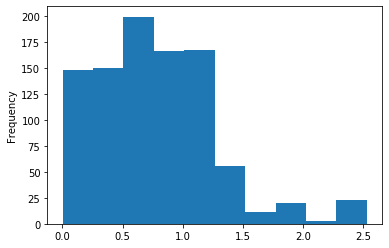

In [63]:
# One TAZ may have more than one transit line intersect with it. 
# Thus, data should be grouped by 'TAZ'.

merged_grp = merged.groupby(['TAZ'])
sum_lod = merged_grp['LOAD'].max()
sum_lod = pd.DataFrame(sum_lod)
sum_lod['LOAD'].plot.hist()

In [64]:
# The length of merged data is close but smaller than the TAZ one. The reason for that is not every taz zone has a
# linestring data goes across it. 

print(len(merged))
print(len(taz))
print(len(sum_lod))

15731
981
943


In [66]:
# Merge loading data on TAZ ID
taz_plot = taz.copy(deep=True)
taz_plot = taz_plot.merge(sum_lod, on='TAZ')
taz_plot.head()

,TAZ,geometry,taz,LOAD
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,0.120
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,0.362
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,0.426
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,0.402
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,0.019


In [67]:
taz_plot['AREA']=taz_plot['geometry'].area
taz_plot['LOAD_AREA']=taz_plot['LOAD']/taz_plot['AREA']
taz_plot.head()

,TAZ,geometry,taz,LOAD,AREA,LOAD_AREA
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,0.120,9.310735e+05,1.288835e-07
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,0.362,1.825218e+06,1.983325e-07
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,0.426,1.360855e+06,3.130385e-07
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,0.402,1.596024e+06,2.518760e-07
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,0.019,1.064261e+06,1.785277e-08


In [68]:
taz_plot.LOAD.describe()

count    943.000000
mean       0.776810
std        0.504401
min        0.001000
25%        0.406500
50%        0.719000
75%        1.093500
max        2.532000
Name: LOAD, dtype: float64

In [69]:
# Assign Weight Factor

sta=taz_plot.LOAD_AREA.describe()

p95 = np.percentile(taz_plot['LOAD_AREA'],95)

taz_plot.loc[taz_plot['LOAD_AREA'] <= sta['25%'], 'taz_WeightFac'] = 0.0
taz_plot.loc[(taz_plot['LOAD_AREA'] >= sta['25%']) & (taz_plot['LOAD_AREA'] <= sta['50%']), 'taz_WeightFac'] = 1.0
taz_plot.loc[(taz_plot['LOAD_AREA'] >= sta['50%']) & (taz_plot['LOAD_AREA'] <= p95), 'taz_WeightFac'] = 2.0
taz_plot.loc[taz_plot['LOAD_AREA'] >= p95, 'taz_WeightFac'] = 4.0

In [71]:
taz_plot.head()

,TAZ,geometry,taz,LOAD,AREA,LOAD_AREA,taz_WeightFac
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,0.120,9.310735e+05,1.288835e-07,0.0
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,0.362,1.825218e+06,1.983325e-07,0.0
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,0.426,1.360855e+06,3.130385e-07,1.0
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,0.402,1.596024e+06,2.518760e-07,0.0
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,0.019,1.064261e+06,1.785277e-08,0.0


## Plotting Job and Population Data Results on SF Map

In [72]:
jobpop_plot.total_bounds

array([5807943.32217987, 2084515.59304632, 6033502.72787987,
       2142542.67893962])

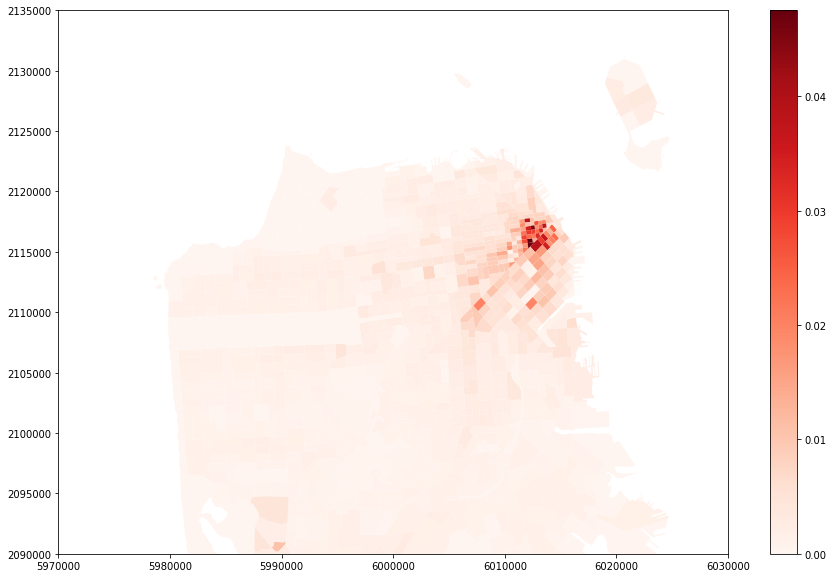

In [73]:
# Plot JobPop Data on MAP

fig,ax = plt.subplots(figsize=(15,10))
ax.set_xlim(5970000, 6030000)
ax.set_ylim(2090000, 2135000)

jobpop_plot.plot(ax=ax, column='jobpop_AREA',           
                 cmap='Reds',
                 legend=True)


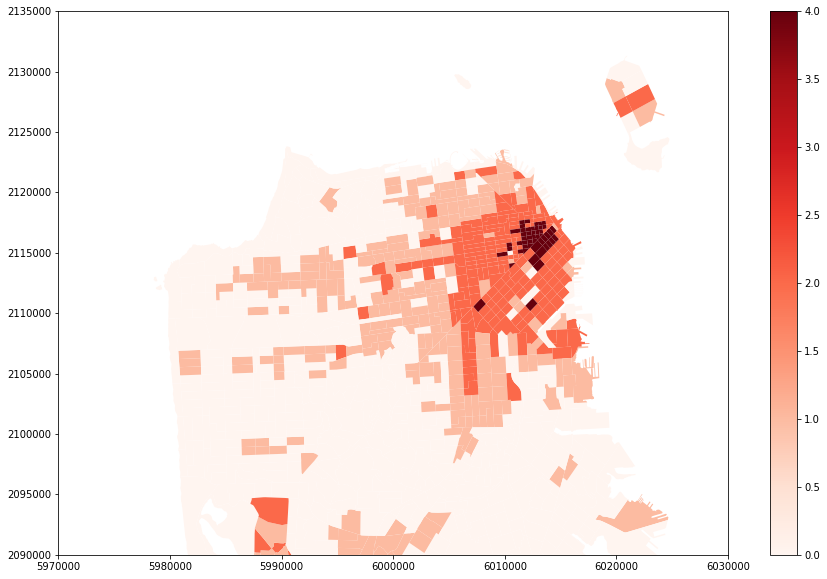

In [74]:
# Plot JobPop Data WEIGHT FACTOR on MAP

fig,ax = plt.subplots(figsize=(15,10))
ax.set_xlim(5970000, 6030000)
ax.set_ylim(2090000, 2135000)

jobpop_plot.plot(ax=ax, column='jp_WeightFac',           
                 cmap='Reds',
                 legend=True)

## Plotting TNC Data Results on SF Map


In [75]:
tnc_plot.total_bounds

array([5807943.32217987, 2084515.59304632, 6033502.72787987,
       2142542.67893962])

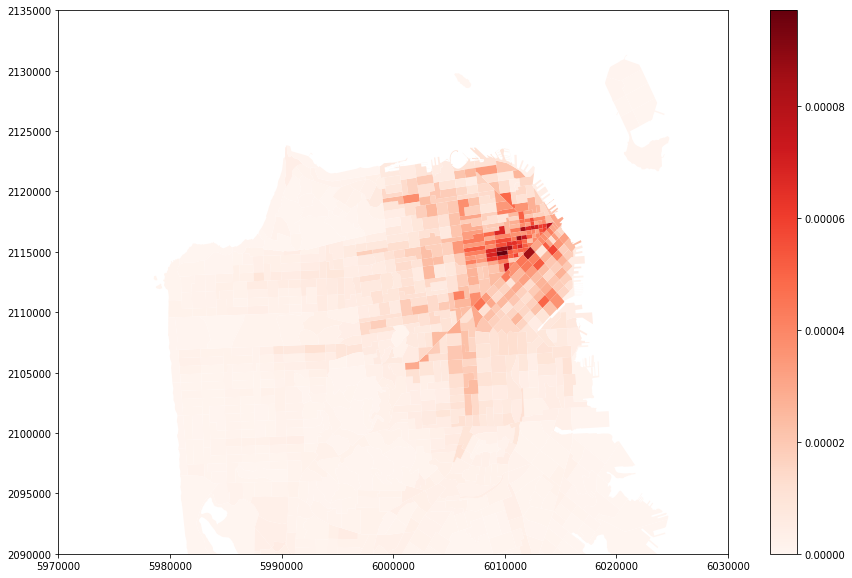

In [76]:
# Plot TNC Data on MAP

fig,ax = plt.subplots(figsize=(15,10))
ax.set_xlim(5970000, 6030000)
ax.set_ylim(2090000, 2135000)

tnc_plot.plot(ax=ax, column='tnc_AREA',           
                 cmap='Reds',
                 legend=True)

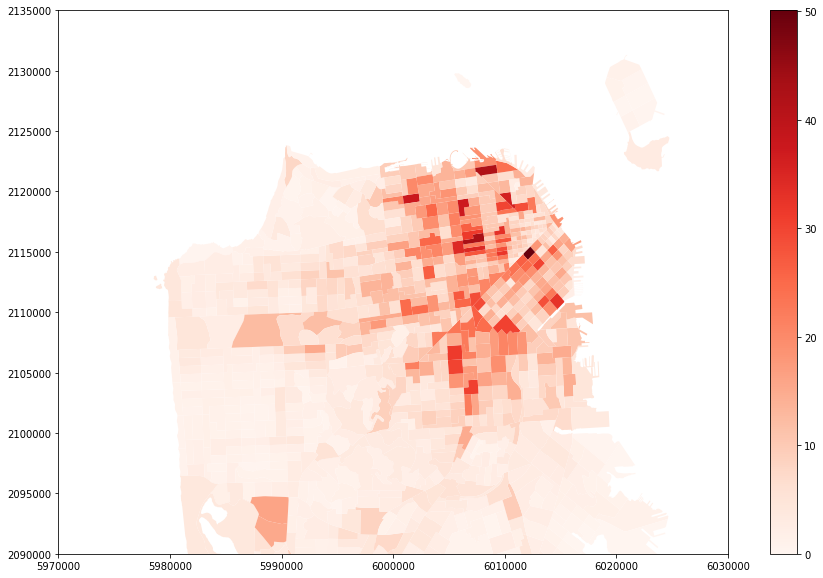

In [77]:
# Plot TNC Data on MAP

fig,ax = plt.subplots(figsize=(15,10))
ax.set_xlim(5970000, 6030000)
ax.set_ylim(2090000, 2135000)

tnc_plot.plot(ax=ax, column='pick_drop',           
                 cmap='Reds',
                 legend=True)

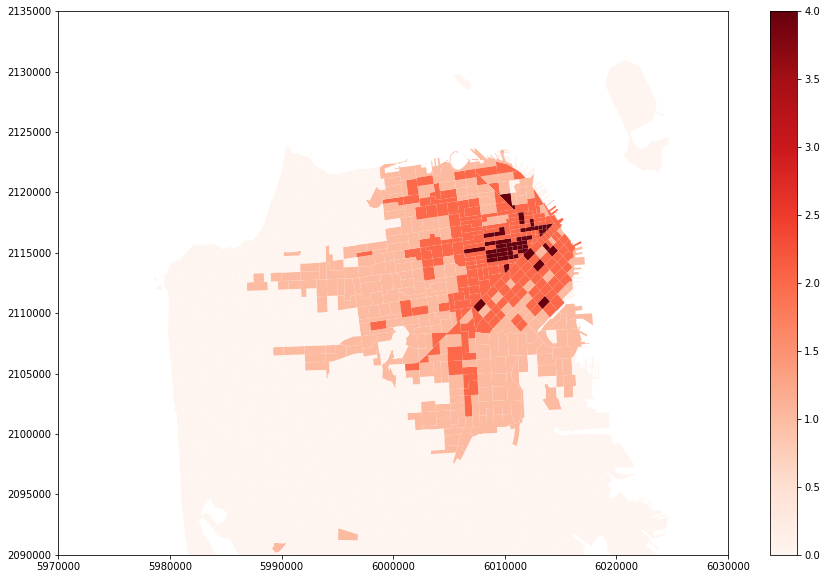

In [78]:
# Plot TNC Data WEIGHT FACTOR on MAP

fig,ax = plt.subplots(figsize=(15,10))
ax.set_xlim(5970000, 6030000)
ax.set_ylim(2090000, 2135000)

tnc_plot.plot(ax=ax, column='tnc_WeightFac',           
                 cmap='Reds',
                 legend=True)

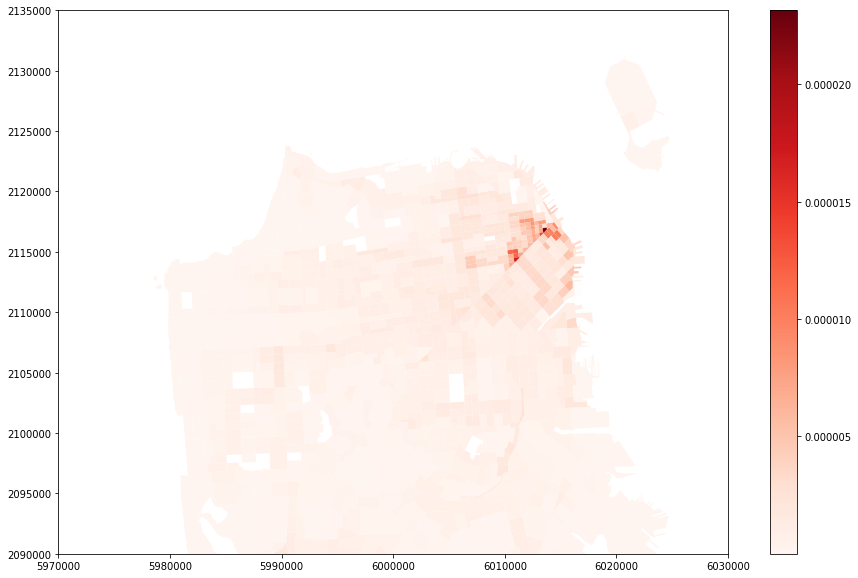

In [79]:
# Plot Transit Data on MAP

fig,ax = plt.subplots(figsize=(15,10))
ax.set_xlim(5970000, 6030000)
ax.set_ylim(2090000, 2135000)

taz_plot.plot(ax=ax, column='LOAD_AREA',           
                 cmap='Reds',
                 legend=True)

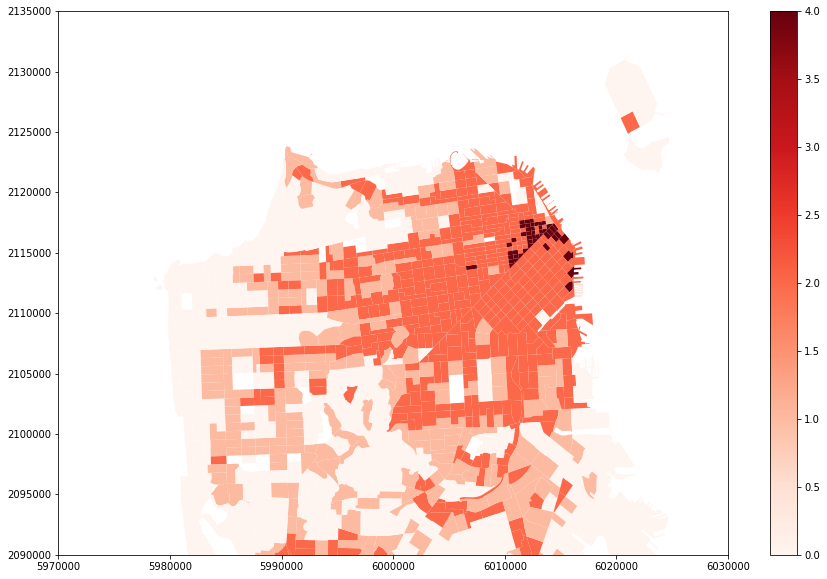

In [80]:
# Plot Transit Data WEIGHT FACTOR on MAP

fig,ax = plt.subplots(figsize=(15,10))
ax.set_xlim(5970000, 6030000)
ax.set_ylim(2090000, 2135000)

taz_plot.plot(ax=ax, column='taz_WeightFac',           
                 cmap='Reds',
                 legend=True)

## Plot Composite Map

In [81]:
# Extract Weight Factor column based on TAZ for all data sets

d1=jobpop_plot[['taz','jp_WeightFac']].copy()
d2=tnc_plot[['taz','tnc_WeightFac']].copy()
d3=taz_plot[['taz','taz_WeightFac']].copy()

In [85]:
# Merge data sets

data1=pd.merge(d1, d2, on='taz', how='left')
data2=pd.merge(data1, d3, on='taz', how='left')

In [86]:
data2.head()

,taz,jp_WeightFac,tnc_WeightFac,taz_WeightFac
0,1,0.0,0.0,0.0
1,2,0.0,0.0,0.0
2,3,0.0,0.0,1.0
3,4,0.0,0.0,0.0
4,5,0.0,0.0,0.0


In [92]:
# Add TAZ column

plot1 = taz.copy(deep=True)
plot1 = plot1.merge(data2, on='taz')

In [93]:
# Sum up all weight factors for all data sets

plot1['WeightFac1'] = plot1['jp_WeightFac'] + plot1['tnc_WeightFac'] + plot1['taz_WeightFac'] 

In [94]:
plot1.head()

,TAZ,geometry,taz,jp_WeightFac,tnc_WeightFac,taz_WeightFac,WeightFac1
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,0.0,0.0,0.0,0.0
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,0.0,0.0,0.0,0.0
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,0.0,0.0,1.0,1.0
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,0.0,0.0,0.0,0.0
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,0.0,0.0,0.0,0.0


In [99]:
# Clean data

plot1.loc[plot1['WeightFac1'] < 0, 'WeightFac1'] = 0.0

plot1.head()

,TAZ,geometry,taz,jp_WeightFac,tnc_WeightFac,taz_WeightFac,WeightFac1
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",1,0.0,0.0,0.0,0.0
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",2,0.0,0.0,0.0,0.0
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",3,0.0,0.0,1.0,1.0
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",4,0.0,0.0,0.0,0.0
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",5,0.0,0.0,0.0,0.0


## Composite Map: Plot Jobpop, TNC, and TAZ data Weight Factor on Map

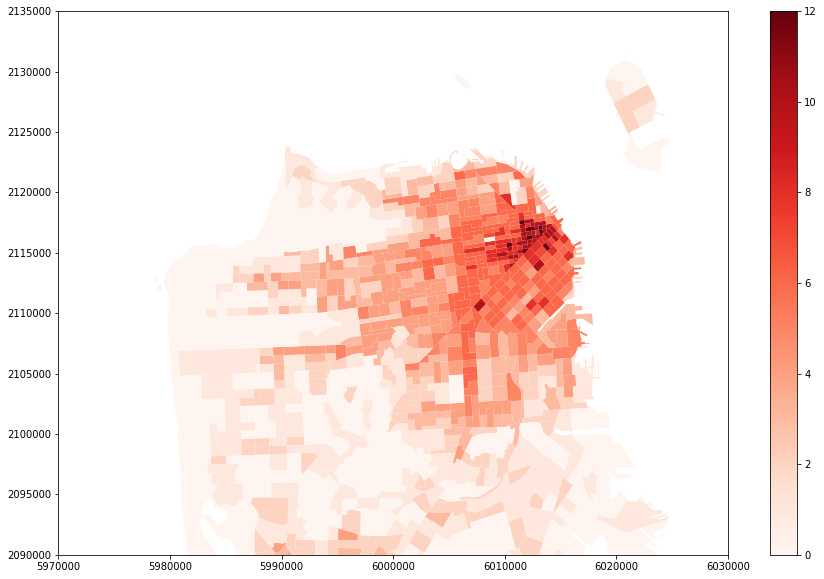

In [98]:
# Plot Jobpop, TNC, and TAZ data WEIGHT FACTOR on MAP

fig,ax = plt.subplots(figsize=(15,10))
ax.set_xlim(5970000, 6030000)
ax.set_ylim(2090000, 2135000)

plot1.plot(ax=ax, column='WeightFac1',           
                 cmap='Reds',
                 legend=True)